# Aufgabe 2 - Tiefe Einblicke ins Institut

Den Code immer nachvollziehbar kommentieren! Bitte beachtet, dass das Notebook von Anfang bis Ende ohne Fehler durchlaufen muss und dass die requirements.txt Datei aktualisiert wird.

## Teilaufgabe a): Trainings-und Testdatenset
## Teilaufgabe b): Verteilung RGB

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from PIL import Image


def thumbnail(img):
    """
    Resizes the image from 224x224 to 30x30
    Image gets reshaped to a 1 dimensional list
    :param img: the image
    :return: resized image as 1 dimensional list
    """
    img_list = np.asarray(img.resize((30, 30))).reshape(1, 2700)
    final_list = np.array([item for sublist in img_list for item in sublist])
    return final_list


class PicData:
    def __init__(self, name):
        file_paths = {
            'prof': "Professorenbuero",
            'hall': "Flur",
            'lab': "Labor",
            'tea': "Teekueche"
        }
        name_to_label = {
            'prof': 1,
            'hall': 2,
            'lab': 3,
            'tea': 4
        }
        pic_amount = len(os.listdir(f"Bilder/{file_paths[name]}"))
        self.path = file_paths[name]
        # self.pics contains all pictures of one room
        self.pics = [Image.open(f"Bilder/{self.path}/{self.path + str(i + 1)}.jpg") for i in range(pic_amount)]
        # self.data contains all histograms of one room
        self.data = np.array([img.histogram() for img in self.pics])
        random.shuffle(self.data)
        #self.labels = np.array([name_to_label[name] for _ in range(len(self.data))])
        #self.img_train, self.img_test, self.lbl_train, self.lbl_test = train_test_split(self.data, self.labels, test_size=0.2)

        # creating data tuple: (data, label)
        # splitting data into train and test data. 80% training data, 20% test data
        self.train = [(self.data[i], name_to_label[name]) for i in range(int(0.8 * len(self.data)))]
        self.test  = [(self.data[i], name_to_label[name]) for i in range(int(0.8 * len(self.data)), len(self.data))]

# lists contain (data, label) tuple for each picture of each room
prof_pics = PicData('prof')
hall_pics = PicData('hall')
lab_pics = PicData('lab')
tea_pics = PicData('tea')

'''print(len(prof_pics.train))
print(len(prof_pics.test))
print(prof_pics.train[0])
print(prof_pics.img_test)
print(prof_pics.lbl_train)
print(prof_pics.lbl_test)
'''
"""
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].hist(prof_pics.histogram, label='prof', bins=768)
ax[0, 1].hist(hall_pics.histogram, label='hall', bins=768)
ax[1, 0].hist(lab_pics.histogram, label='lab', bins=768)
ax[1, 1].hist(tea_pics.histogram, label='tea', bins=768)

ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()

plt.show()
"""




"\nfig, ax = plt.subplots(2, 2, figsize=(10, 10))\nax[0, 0].hist(prof_pics.histogram, label='prof', bins=768)\nax[0, 1].hist(hall_pics.histogram, label='hall', bins=768)\nax[1, 0].hist(lab_pics.histogram, label='lab', bins=768)\nax[1, 1].hist(tea_pics.histogram, label='tea', bins=768)\n\nax[0, 0].legend()\nax[0, 1].legend()\nax[1, 0].legend()\nax[1, 1].legend()\n\nplt.show()\n"

## Teilaufgabe c): Training und Test mit Random Forest

In [42]:
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier

# creating a list containing all the training data: [[histogram, label],...]
complete_train = list(prof_pics.train) + list(hall_pics.train) + list(lab_pics.train) + list(tea_pics.train)
# creating a list containing all the test data: [[histogram, label],...]
complete_test = list(prof_pics.test) + list(hall_pics.test) + list(lab_pics.test) + list(tea_pics.test)
random.shuffle(complete_train)
random.shuffle(complete_test)

# splitting list items X_ = histogram, y_ = label
X_train = [item[0] for item in complete_train]
y_train = [item[1] for item in complete_train]
X_test = [item[0] for item in complete_test]
y_test = [item[1] for item in complete_test]

# train the random forest
rf = RandomForestClassifier(n_estimators=155)
rf.fit(X_train, y_train)

#print(r2_score(y_train, rf.predict(X_train)))

#complete_image_list = list(prof_pics.img_train) + list(hall_pics.img_train) + list(lab_pics.img_train) + #list(tea_pics.img_train)
#complete_label_list = list(prof_pics.lbl_train) + list(hall_pics.lbl_train) + list(lab_pics.lbl_train) + list(tea_pics.lbl_train)
#rf.fit(complete_image_list, complete_label_list)


RandomForestClassifier(n_estimators=155)

Predictions:  [3 2 3 3 3 2 4 1 3 4 3 1 2 2 4 2 2 3 1 4]
Expected:  [3, 2, 3, 4, 1, 2, 4, 1, 3, 4, 3, 1, 2, 2, 4, 1, 2, 3, 1, 4]
Accuracy: 85.0 %
F1 Score: 0.85
Recall: 0.85
Precision: 0.85
Confusion matrix: 


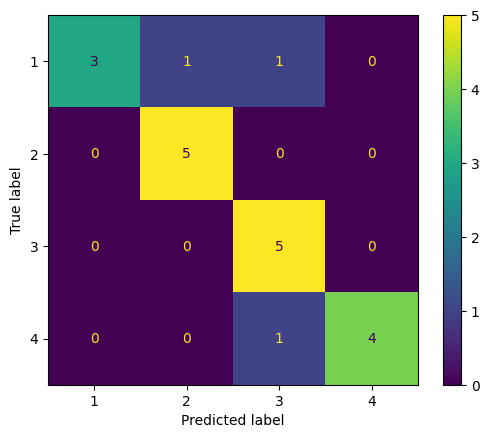

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score, precision_score

def score (y_expect, y_pred):
    """
    gives information about the random forests stats.
    As print out: Forest Predictions, Expectations, Accuracy, F1 Score, Recall and Precision.
    As plot: Confusion matrix
    :param y_expect: Forest Predictions
    :param y_pred: Forest Expectations
    :return:
    """
    errors = 0
    for i in range(len(y_pred)):
        if y_pred[i] != y_expect[i]:
            errors += 1

    #conf_matrix = confusion_matrix(y_expect, y_pred)
    ConfusionMatrixDisplay.from_predictions(y_expect, y_pred)
    accuracy = (len(y_expect)-errors)/len(y_expect) * 100

    print('Predictions: ', str(y_pred))
    print('Expected: ', str(y_expect))
    # print('Mean Absolute Error:', str(round(np.mean(errors), 2)) + '°')
    print('Accuracy:', round(accuracy, 2), '%')
    print("F1 Score:", f1_score(y_expect, y_pred, average='micro'))
    print("Recall:", recall_score(y_expect, y_pred, average='micro'))
    print("Precision:", precision_score(y_expect, y_pred, average='micro'))
    print('Confusion matrix: ')
    # str(conf_matrix))

    plt.show()

# for one room only
# test_list = tea_pics.test
# test_data = [item[0] for item in test_list]
# test_lbl = [item[1] for item in test_list]
# y_pred = rf.predict(test_data)
# score(test_lbl, y_pred)

y_pred = rf.predict(X_test)
score(y_test, y_pred)

## Teilaufgabe d): Hyperparameteroptimierung

Best Params:  {'max_depth': 60}
Scores of the new forest:
Predictions:  [3 2 3 3 3 2 4 1 3 4 3 1 2 2 4 2 2 3 1 4]
Expected:  [3, 2, 3, 4, 1, 2, 4, 1, 3, 4, 3, 1, 2, 2, 4, 1, 2, 3, 1, 4]
Accuracy: 85.0 %
F1 Score: 0.85
Recall: 0.85
Precision: 0.85
Confusion matrix: 


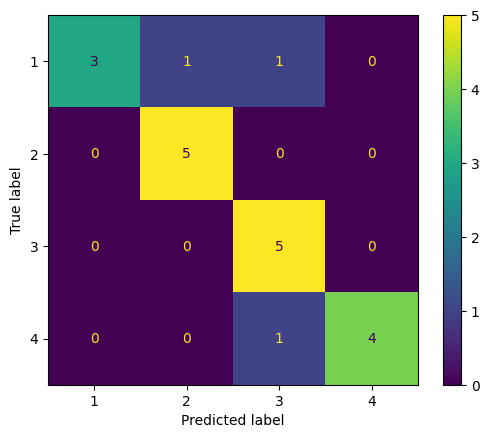

In [44]:
from sklearn.model_selection import GridSearchCV
# choosing max depth parameter
param_grid = {#'n_estimators': [10, 55, 100, 155],
              'max_depth': [60, 80, None],
              #'max_features': ['sqrt', 'log2', None],
              #'min_samples_leaf': [1, 3, 5]
              #'min_samples_split': [2, 3, 4]
              }
rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5, scoring='r2') # verbose =2,  n_jobs = -1
grid_search.fit(X_train, y_train)
print("Best Params: ", grid_search.best_params_) # differs every run, but 80 seems to be the best

print("Scores of the new forest:")
rf = RandomForestClassifier(max_depth = grid_search.best_params_["max_depth"])
rf.fit(X_train, y_train)
score(y_test, rf.predict(X_test))


## Teilaufgabe e): Dimensionalitätsreduktion

Predictions:  [3 2 3 4 3 2 4 1 3 4 3 1 2 2 4 2 1 3 1 4]
Expected:  [3, 2, 3, 4, 1, 2, 4, 1, 3, 4, 3, 1, 2, 2, 4, 1, 2, 3, 1, 4]
Accuracy: 85.0 %
F1 Score: 0.85
Recall: 0.85
Precision: 0.85
Confusion matrix: 


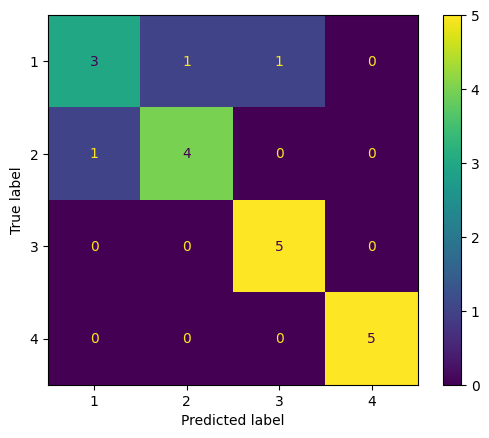

In [45]:
from sklearn.decomposition import PCA

# Calculate eigenvectors and eigenvalues of the covariance matrix
X_train = np.array(X_train)
mean_vec = np.mean(X_train, axis=0)
cov_mat = np.cov(X_train.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Calculate the explained variance from the eigenvalues
tot = sum(eig_vals)
var_exp = [(i / tot) * 100 for i in sorted(eig_vals, reverse=True)] # Individual explained variance
cum_var_exp = np.cumsum(var_exp) # Cumulative explained variance

# Find the number of components that explain 90% of the variance
n = [n for n,i in enumerate(cum_var_exp) if i > 90][0]

pca = PCA(n_components=n)
pca.fit(X_train)
X_20d = pca.transform(X_train)


rf = RandomForestClassifier(n_estimators=155)
rf = rf.fit(X_20d, y_train)

test_20d = pca.transform(X_test)
score(y_test, rf.predict(test_20d))

